In [ ]:
# Work 07
## Loading dataframes of labelled masks with mask properties
## Build classification model for extraction of curbs
## Build classification model for whole scene entropy
## Build classification model for ground scene entropy

In [62]:
# loading libraries
import torch
torch.cuda.empty_cache() 
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:100000"
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
os.getcwd()
import glob
import shapely
from shapely.geometry import Polygon
import shapely.plotting
import pandas as pd
from PIL import Image as ima
import warnings
import joblib

from sklearn import * 
from sklearn import datasets
from sklearn.datasets import load_digits
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import seaborn as sn

In [65]:
# loading written functions
from mtp_function_yl import *

In [199]:
# loaindg dataframe of labelled masks and calculated mask properties
df = pd.read_csv('/home/yelhe/script/mt/input/df_all_n.csv')
df = df.replace({True:1, False:0})
df['label'].unique()

array(['s', 'pa', 'p', 'r', 'b', 'bi', 'o', 't', 'v', 'ct', 'h', 'curb',
       'ep', 'm', 'pm', 'vp', 'sw', 'rs', 'rgs', 'sl', 'mo', 'bp', 'mb',
       'bw', 'ra', 'train', 'bus', 'ts', 'tram', 'rp', 'tb', 'lp', 'ri',
       'tl', 'bl', 'z', 'sp', 'wp', 'sh', 'st', 'li', 'tc', 'ch', 'bip',
       'rb', 'tlp'], dtype=object)

### For curb extraction

In [ ]:
# selecting only the bottom half of the images using threshold for topm
df_l = df.loc[df['topm'] >= 300]
# simplifying label groups
df_l.loc[(df_l.label_group == 'means_of_transportation'), 'label_group'] = 'other'
df_l.loc[(df_l.label_group == 'building'), 'label_group'] = 'other'
# preparing for classification
le = LabelEncoder()
df_l['labelgroup_index'] = le.fit_transform(df_l['label_group'])
y = df_l['label_group']
y = le.transform(y)

In [17]:
# checking statistics
df2= df_l
df2.groupby(['label_group','labelgroup_index']).size().reset_index().rename(columns={0:'count'})

,label_group,labelgroup_index,count
0,curb,0,49
1,infrastructure,1,535
2,other,2,1355
3,vegetation,3,221


In [19]:
# dropping irrelevant columns
dfc = df_l
# Drop info columns
dfc = dfc.drop(['label', 'Nr', 'label_group', 'mask', 'labelgroup_index'], axis = 1)
# Drop variables which don't help much
dfc = dfc.drop(['isconvex','is_cen_inside','is_mce_inside', 'leftm', 'rightm', 'topm'], axis = 1)

In [ ]:
# applying random forest classification
X = dfc
y = y
# splitting for train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.28, 
                                                    random_state = 10)
X_train.shape, X_test.shape
# building classifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [58]:
# evaluating performance of random forest classification for curb extraction
print("Train data accuracy:",accuracy_score(y_true = y_train, y_pred = rf.predict(X_train)))
print("Test data accuracy:",accuracy_score(y_true = y_test, y_pred = y_pred_rf))

Train data accuracy: 0.9884244372990354
Test data accuracy: 0.8380165289256198


[[  7   3   1   0]
 [  2 121  38   0]
 [  0  19 341   8]
 [  0   0  27  38]]


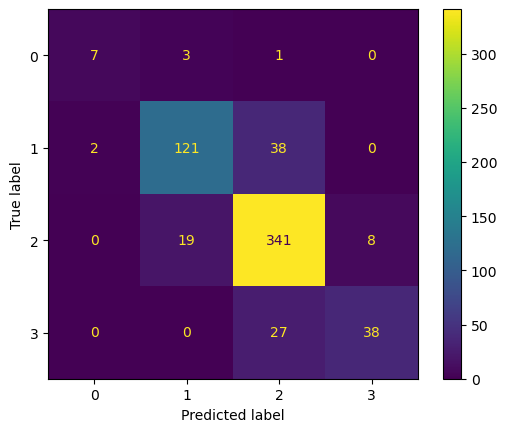

In [59]:
# plotting confusion matrix
confusion_matrix_rf = metrics.confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)
cm_display_rf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf)
cm_display_rf.plot()

In [60]:
# evaluating performance of random forest classification for curb extraction
acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
print('accuracy', acc_rf)
pre_rf = metrics.precision_score(y_test, y_pred_rf, average = None)
print('precision', pre_rf)
senrec_rf = metrics.recall_score(y_test, y_pred_rf, average = None)
print('sensitivity recall', senrec_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf, average = None)
print('f1 score', f1_rf)

accuracy 0.8380165289256198
precision [0.77777778 0.84615385 0.83783784 0.82608696]
sensitivity recall [0.63636364 0.7515528  0.92663043 0.58461538]
f1 score [0.7        0.79605263 0.88       0.68468468]


Text(0, 0.5, 'feature')

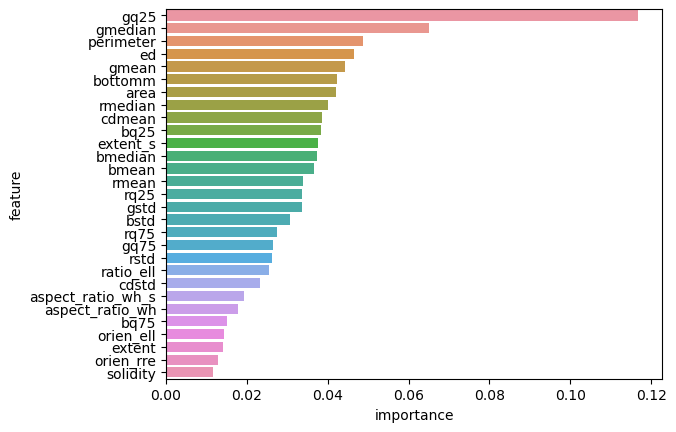

In [61]:
# plotting feature importance
feature_name = list(dfc.columns.values.tolist())
importances = rf.feature_importances_
df_rf = pd.DataFrame({'features':feature_name, 'importances':importances})
df_rf.sort_values(by = ['importances'], ascending = False, inplace = True)
sn.barplot(x = df_rf['importances'], y = df_rf['features'])
plt.xlabel('importance')
plt.ylabel('feature')

In [ ]:
# saving random forest classification model built for curb extraction
joblib.dump(rf, "my_random_forest_1.joblib")

### For entropy calculation - whole scene

In [89]:
# preparing for classification
df_e = df
le_e = LabelEncoder()
df_e['labelgroup_index'] = le_e.fit_transform(df_e['label_group'])
y_e = df_e['label_group']
y_e = le_e.transform(y_e)
df_e.groupby(['label_group','labelgroup_index']).size().reset_index().rename(columns={0:'count'})

,label_group,labelgroup_index,count
0,building,0,401
1,curb,1,49
2,infrastructure,2,717
3,means_of_transportation,3,189
4,other,4,1822
5,sky,5,112
6,vegetation,6,644


In [90]:
# dropping irrelevant columns
dfe = df_e
dfe = dfe.drop(['label', 'Nr', 'label_group', 'mask', 'labelgroup_index'], axis = 1)
dfe = dfe.drop(['isconvex', 'is_cen_inside', 'is_mce_inside'], axis = 1)

In [186]:
# applying random forest classification for calculating whole scene entropy
Xe = dfe
ye = y_e
X_train, X_test, y_train, y_test = train_test_split(Xe, ye, test_size = 0.3, random_state = 8)
X_train.shape, X_test.shape
rfe = RandomForestClassifier(n_estimators = 10, random_state = 8)
rfe.fit(X_train, y_train)
y_pred_rfe = rfe.predict(X_test)

In [189]:
# evaluating performance of random forest classification for calculating whole scene entropy
print("Train data accuracy:",accuracy_score(y_true = y_train, y_pred = rfe.predict(X_train)))
print("Test data accuracy:",accuracy_score(y_true = y_test, y_pred = y_pred_rfe))

Train data accuracy: 0.9960043588812205
Test data accuracy: 0.7832345469940728


[[ 71   0   1   0  30   0   1]
 [  0   6   1   0   0   0   0]
 [  1   3 159   1  51   0   1]
 [  3   0   0  23  34   0   0]
 [ 11   0  30   3 487   0  18]
 [  3   0   1   0   3  30   0]
 [  9   0   0   0  51   0 149]]


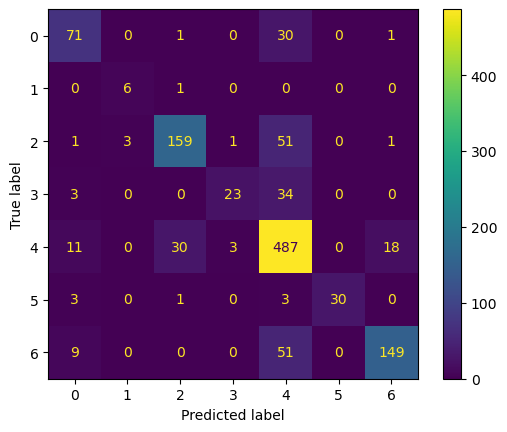

In [190]:
# plotting confusion matrix
confusion_matrix_rfe = metrics.confusion_matrix(y_test, y_pred_rfe)
print(confusion_matrix_rfe)
cm_display_rfe = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rfe)
cm_display_rfe.plot()
# cm_display_rfe.plot(cmap = 'PuBu')
# plt.box(False)
# plt.savefig('cm_1_entropywhole.png', dpi = 300, edgecolor = None, 
#              transparent = True, bbox_inches = 'tight')

In [192]:
# evaluating performance of random forest classification for calculating whole scene entropy
acc_rfe = metrics.accuracy_score(y_test, y_pred_rfe)
print('accuracy', acc_rfe)
pre_rfe = metrics.precision_score(y_test, y_pred_rfe, average = None)
print('precision', pre_rfe)
senrec_rfe = metrics.recall_score(y_test, y_pred_rfe, average = None)
print('sensitivity recall', senrec_rfe)
f1_rfe = metrics.f1_score(y_test, y_pred_rfe, average = None)
print('f1 score', f1_rfe)
pre_rfe_m = np.mean(pre_rfe)
senrec_rfe_m = np.mean(senrec_rfe)
f1_rfe_m = np.mean(f1_rfe)
print('mean precision', pre_rfe_m)
print('mean recall', senrec_rfe_m)
print('mean f1 score', f1_rfe_m)

mean precision 0.8135954525644431
mean recall 0.7252435080426893
mean f1 score 0.7509708557410778


Text(0, 0.5, 'feature')

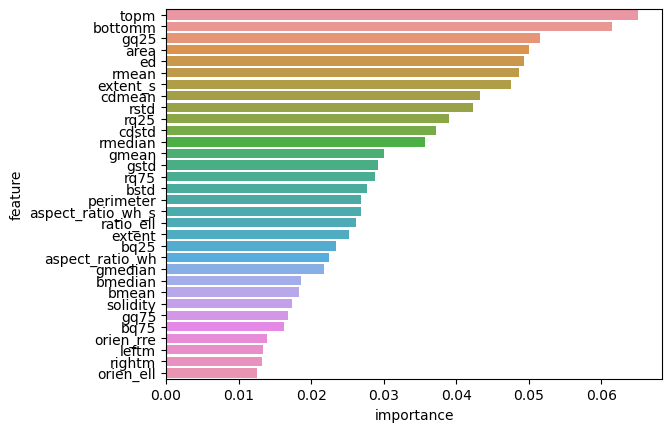

In [193]:
# plotting feature importance
feature_name = list(dfe.columns.values.tolist())
importances = rfe.feature_importances_
df_rfe = pd.DataFrame({'features':feature_name, 'importances':importances})
df_rfe.sort_values(by = ['importances'], ascending = False, inplace = True)
sn.barplot(x = df_rfe['importances'], y = df_rfe['features'])
plt.xlabel('importance')
plt.ylabel('feature')
# plt.figure(figsize = (12,8))
# feature_name = list(dfe.columns.values.tolist())
# importances = rfe.feature_importances_
# df_rfe = pd.DataFrame({'features':feature_name, 'importances':importances})
# df_rfe.sort_values(by = ['importances'], ascending = False, inplace = True)
# sn.barplot(x = df_rfe['importances'], y = df_rfe['features'],
#           palette = "PuBu_r")
# plt.xlabel('importance')
# plt.ylabel('feature')
# plt.box(False)
# plt.savefig('rfimportance1_entropywhole.png', dpi = 300, edgecolor = None, 
#              transparent = True, bbox_inches = 'tight')

In [196]:
# saving random forest classification model built for calculating whole scene entropy
joblib.dump(rfe, "my_random_forest_2_whole7.joblib")

['my_random_forest_2_whole7.joblib']

### For entropy calculation - ground scene

In [222]:
# preparing for ground scene classification
dfr = df
dfin = dfr.loc[(dfr['label_group'] == 'infrastructure')|(dfr['label_group'] == 'curb')]
dfin = dfin.drop(['mask', 'labelgroup_index'], axis = 1)
dfin.groupby(['label']).size().reset_index().rename(columns={0:'count'})

,label,count
0,bl,7
1,bw,9
2,ch,1
3,ct,12
4,curb,49
5,ep,18
6,lp,8
7,m,40
8,pa,92
9,r,125


In [216]:
# categorising detailed labels of ground level into general label groups
dfin = dfin.assign(label_group_ground = 0)
dfin.loc[(dfin.label == 'r')|(dfin.label == 'rp'), 'label_group_ground'] = 'road'
dfin.loc[(dfin.label == 'bl'), 'label_group_ground'] = 'bike_lane'
dfin.loc[(dfin.label == 'pa'), 'label_group_ground'] = 'pavement'
dfin.loc[(dfin.label == 'curb'), 'label_group_ground'] = 'curb'
dfin.loc[(dfin.label == 'm'), 'label_group_ground'] = 'manhole'
dfin.loc[(dfin.label == 'z')|(dfin.label == 'bw')|(dfin.label == 'rgs')|(dfin.label == 'zp'),
         'label_group_ground'] = 'ground_sign'
dfin.loc[(dfin.label == 'ch')|(dfin.label == 'ep')|(dfin.label == 'lp')|
         (dfin.label == 'rb')|(dfin.label == 'rs')|(dfin.label == 'sl')|
         (dfin.label == 'tl')|(dfin.label == 'tc')|(dfin.label == 'sw')|
         (dfin.label == 'tb')|(dfin.label == 'ts')|(dfin.label == 'slp')| 
         (dfin.label == 'tlp')|(dfin.label == 'ra')|(dfin.label == 'st')|
         (dfin.label == 'wp')|(dfin.label == 'ct'), 'label_group_ground'] = 'other'

In [226]:
# checking distribution of label groups for ground scene
dfin.groupby(['label_group_ground']).size().reset_index().rename(columns={0:'count'})
dfi = dfin
le_i = LabelEncoder()
dfi['lgg_index'] = le_i.fit_transform(dfi['label_group_ground'])
y_i = dfi['label_group_ground']
y_i = le_i.transform(y_i)
dfi.groupby(['label_group_ground','lgg_index']).size().reset_index().rename(columns={0:'count'})

,label_group_ground,lgg_index,count
0,bike_lane,0,7
1,curb,1,49
2,ground_sign,2,217
3,manhole,3,40
4,other,4,226
5,pavement,5,92
6,road,6,135


In [230]:
# dropping irrelevant columns
dfi = dfi.drop(['label', 'Nr', 'label_group', 'label_group_ground', 'lgg_index',
                'isconvex', 'is_cen_inside', 'is_mce_inside'], axis = 1)

In [240]:
# applying random forest classification for calculating ground scene entropy
Xi = dfi
yi = y_i
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xi, yi, test_size = 0.45, random_state = 12)
X_train1.shape, X_test1.shape
rfi = RandomForestClassifier(n_estimators = 12, random_state = 12)
rfi.fit(X_train1, y_train1)
y_pred_rfi = rfi.predict(X_test1)

((574, 32), (192, 32))

In [242]:
# evaluating performance of random forest classification for calculating ground scene entropy
print("Train data accuracy:",accuracy_score(y_true = y_train1, y_pred = rfi.predict(X_train1)))
print("Test data accuracy:",accuracy_score(y_true = y_test1, y_pred = y_pred_rfi))

Train data accuracy: 0.9947735191637631
Test data accuracy: 0.8541666666666666


[[ 5  3  1  0  1  0]
 [ 1 49  4  0  4  0]
 [ 0  0 11  0  0  0]
 [ 0  1  1 59  0  0]
 [ 0  0  0  0 17  1]
 [ 0  1  0  1  9 23]]


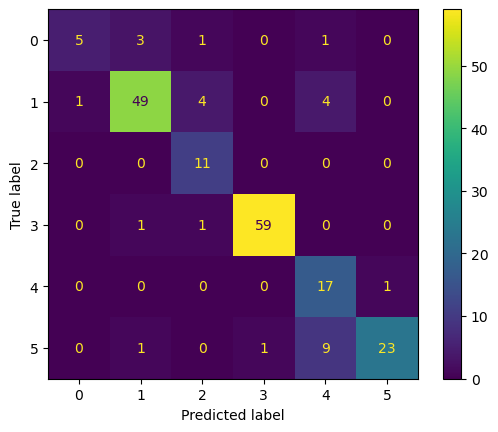

In [243]:
# plotting confusion matrix
confusion_matrix_rfi = metrics.confusion_matrix(y_test1, y_pred_rfi)
print(confusion_matrix_rfi)
cm_display_rfi = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rfi)
cm_display_rfi.plot()

In [245]:
# evaluating performance of random forest classification for calculating ground scene entropy
acc_rfi = metrics.accuracy_score(y_test1, y_pred_rfi)
print('accuracy', acc_rfi)
pre_rfi = metrics.precision_score(y_test1, y_pred_rfi, average = None)
print('precision', pre_rfi)
senrec_rfi = metrics.recall_score(y_test1, y_pred_rfi, average = None)
print('sensitivity recall', senrec_rfi)
f1_rfi = metrics.f1_score(y_test1, y_pred_rfi, average = None)
print('f1 score', f1_rfi)
pre_rfi_m = np.mean(pre_rfi)
senrec_rfi_m = np.mean(senrec_rfi)
f1_rfi_m = np.mean(f1_rfi)
print('mean precision', pre_rfi_m)
print('mean recall', senrec_rfi_m)
print('mean f1 score', f1_rfi_m)

mean precision 0.8129755546185021
mean recall 0.8221592889401222
mean f1 score 0.7913169827634672


Text(0, 0.5, 'feature')

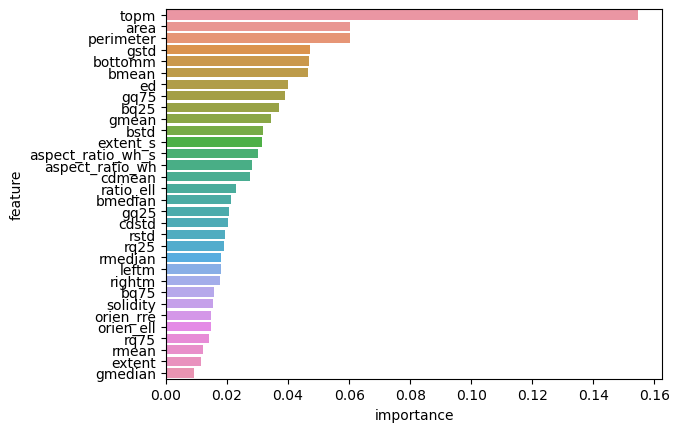

In [246]:
# plotting feature importance
feature_name = list(dfe.columns.values.tolist())
importances = rfi.feature_importances_
df_rfi = pd.DataFrame({'features':feature_name, 'importances':importances})
df_rfi.sort_values(by = ['importances'], ascending = False, inplace = True)
sn.barplot(x = df_rfi['importances'], y = df_rfi['features'])
plt.xlabel('importance')
plt.ylabel('feature')

In [247]:
# saving random forest classification model built for calculating ground scene entropy
joblib.dump(rfi, "my_random_forest_3_ground7.joblib")

['my_random_forest_3_ground7.joblib']